# Lumped Model Calibration

- Please change the Path in the following cell to the directory where you stored the case study data

In [1]:
import os
Path = "F:/02Case studies/Coello"
os.chdir(Path)

### Modules

In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import Hapi.hbv_bergestrom92 as HBVLumped

from Hapi.calibration import Calibration
from Hapi.routing import Routing
from Hapi.run import Run
import Hapi.performancecriteria as PC

### Paths

In [3]:
Parameterpath = "Hapi/Model/results/parameters/01lumped model/Coello_Lumped15062020-1.txt"
Meteopath = "HAPI/Data/00inputs/Lumped Model/"
Path = "HAPI/Data/00inputs/Basic_inputs/"
SaveTo = "Hapi/Model/results/"

### Meteorological data

In [4]:
start = "2009-01-01"
end = "2011-12-31"
name = "Coello"

Coello = Calibration(name, start, end)
Coello.ReadLumpedInputs(Meteopath + "meteo_data-MSWEP.csv")

Lumped Model inputs are read successfully


### Basic_inputs

In [5]:
# catchment area
AreaCoeff = 1530
# temporal resolution
# [Snow pack, Soil moisture, Upper zone, Lower Zone, Water content]
InitialCond = [0,10,10,10,0]
# no snow subroutine
Snow = 0
Coello.ReadLumpedModel(HBVLumped, AreaCoeff, InitialCond)

Lumped model is read successfully


# Calibration parameters

In [6]:
# Calibration boundaries
UB = pd.read_csv(Path + "/lumped/UB-3.txt", index_col = 0, header = None)
parnames = UB.index
UB = UB[1].tolist()
LB = pd.read_csv(Path + "/lumped/LB-3.txt", index_col = 0, header = None)
LB = LB[1].tolist()

Maxbas = True
Coello.ReadParametersBounds(UB, LB, Snow, Maxbas=Maxbas)

# read parameters obtained from previous run to use it as initial values
# parameters = pd.read_csv(Parameterpath, index_col = 0, header = None)
# parameters = parameters[1].tolist()
parameters = []
# Routing
Route=1
RoutingFn = Routing.TriangularRouting1

Basic_inputs=dict(Route=Route, RoutingFn=RoutingFn, InitialValues = parameters)

### Objective function
# outlet discharge
Coello.ReadDischargeGauges(Meteopath+"Qout_c.csv", fmt="%Y-%m-%d")

OF_args=[]
OF=PC.RMSE

Coello.ReadObjectiveFn(PC.RMSE, OF_args)

Parameters bounds are read successfully
Gauges data are read successfully
Objective function is read successfully


# Calibration

API options
Create the options dictionary all the optimization parameters should be passed
to the optimization object inside the option dictionary:


to see all options import Optimizer class and check the documentation of the
method setOption

In [7]:
ApiObjArgs = dict(hms=100, hmcr=0.95, par=0.65, dbw=2000, fileout=1, xinit =0,
                      filename=SaveTo + "parameters/01lumped model/Coello_History"+str(dt.datetime.now())[0:10]+".txt")

for i in range(len(ApiObjArgs)):
    print(list(ApiObjArgs.keys())[i], str(ApiObjArgs[list(ApiObjArgs.keys())[i]]))

# pll_type = 'POA'
pll_type = None

ApiSolveArgs = dict(store_sol=True, display_opts=True, store_hst=True, hot_start=False)

OptimizationArgs=[ApiObjArgs, pll_type, ApiSolveArgs]

hms 100
hmcr 0.95
par 0.65
dbw 2000
fileout 1
xinit 0
filename Hapi/Model/results/parameters/01lumped model/Coello_History2021-04-13.txt


### Run Calibration

In [8]:
cal_parameters = Coello.LumpedCalibration(Basic_inputs, OptimizationArgs, printError=None)

print("Objective Function = " + str(round(cal_parameters[0],2)))
print("Parameters are " + str(cal_parameters[1]))
print("Time = " + str(round(cal_parameters[2]['time']/60,2)) + " min")

Calibration starts
75.97230471026135
35.12370311929097
26.736193991743843
47.59214141206876
69.64192136208666
39.26329985145338
54.39070043322197
44.91502122745141
69.53375042619584
53.14334971495579
99.18309458766417
32.80779180866017
28.128792886783565
66.83634818170908
33.26517989794351
43.37339220748546
71.94429915723916
65.10157417694879
48.4442668749925
71.1312348024002
63.02534518235048
89.72825940868006
25.15429819853976
41.590147830419355
32.409820621217776
69.25552497930327
78.67865414756078
32.794422985197215
49.19893317156736
38.058692438487405
62.269769289553196
41.69924970429968
25.640441031817595
68.23518685180184
29.6709780661591
68.34608839563684
79.4628856858016
41.76215116982465
71.2982443742673
64.27758244358635
69.60700667905579
46.985912326552985
51.38860152956666
57.483714718849264
83.67866012147273
87.16778395330812
28.37274698259952
64.12657648896803
78.17174304236528
44.947300533973554
82.53796212012337
26.48356306691962
84.3256678020809
59.50037836377856
58.2

### Run the Model

In [9]:
Coello.Parameters = cal_parameters[1]
Run.RunLumped(Coello, Route, RoutingFn)

Model Run has finished


### Calculate Performance Criteria

In [10]:
Metrics = dict()

Qobs = Coello.QGauges[Coello.QGauges.columns[0]]

Metrics['RMSE'] = PC.RMSE(Qobs, Coello.Qsim['q'])
Metrics['NSE'] = PC.NSE(Qobs, Coello.Qsim['q'])
Metrics['NSEhf'] = PC.NSEHF(Qobs, Coello.Qsim['q'])
Metrics['KGE'] = PC.KGE(Qobs, Coello.Qsim['q'])
Metrics['WB'] = PC.WB(Qobs, Coello.Qsim['q'])

print("RMSE= " + str(round(Metrics['RMSE'],2)))
print("NSE= " + str(round(Metrics['NSE'],2)))
print("NSEhf= " + str(round(Metrics['NSEhf'],2)))
print("KGE= " + str(round(Metrics['KGE'],2)))
print("WB= " + str(round(Metrics['WB'],2)))

RMSE= 21.98
NSE= 0.3
NSEhf= 0.31
KGE= 0.6
WB= 95.18


### Plotting Hydrograph

(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Lumped Model'}, xlabel='Time', ylabel='Discharge m3/s'>)

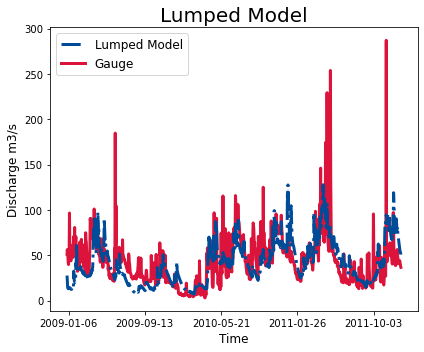

In [11]:
gaugei = 0
plotstart = "2009-01-01"
plotend = "2011-12-31"
Coello.PlotHydrograph(plotstart, plotend, gaugei, Title= "Lumped Model")

### Save the Parameters

In [13]:
ParPath = SaveTo + "parameters/02lumped parameters/Parameters" + str(dt.datetime.now())[0:10] + ".txt"
parameters = pd.DataFrame(index=parnames)
parameters['values'] = cal_parameters[1]
parameters.to_csv(ParPath, header=None, float_format="%0.4f")

### Save Results

In [14]:
StartDate = "2009-01-01"
EndDate = "2010-04-20"

Path = SaveTo + "Results-Lumped-Model" + str(dt.datetime.now())[0:10] + ".txt"
Coello.SaveResults(Result=5, StartDate=StartDate, EndDate=EndDate, Path=Path)

Data is saved successfully
